# Ejercicio Practico 2
## Regresión Lineal

Este ejemplo práctico en realidad es continuación del anterior puesto que utilizamos el dataset que habíamos preparado. Es más, en el anterior, habíamos tomado decisiones asumiendo que en esta fase trataríamos de modelizar con un modelo de regresión lineal.

El objetivo de esta práctica es entrenar un modelo de regresión lineal, interpretar sus parametros y evaluar la bondad del modelo.

### 1. Entrenamiento del modelo de regresión lineal

En primer lugar vamos a importar las librerías de python que serán necesarias para realizar el analisis:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from scipy.stats import boxcox, shapiro
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, RegressorMixin
from relativeImp import relativeImp

pd.set_option('display.max_rows', None)

# Cargar el dataset desde el archivo CSV
data = pd.read_csv('vehicles_prep.csv')

Antes de nada vamos a asegurarnos de que todas las variables son numéricas ya que al importar los datos es muy posible que muchas sean tomadas con otro formato, especialmente las dummy, que las importará como boolean.

In [2]:
# Convertir booleanos a numéricos
boolean_columns = data.select_dtypes(include='bool').columns
data[boolean_columns] = data[boolean_columns].astype(int)

# Asegurar que los datos son numéricos
data = data.apply(pd.to_numeric, errors='coerce')

Vamos a separar la variable objetivo ***price*** de las variables predictoras. Esto ons daraá cierta flexibilidad par luego utilizar ambos conjuntos de forma independiente para hacer validaciones y pruebas.

In [3]:
# Definir la variable objetivo (y) y las predictoras (X)
X = data.drop('price', axis=1)
y = data['price']

Ahora vamos a dividir nuestro conjunto de datos 2 partes: una para entrenamiento (80% de los datos) y otra para validación o test (20% restante).

In [4]:
# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

El siguiente paso es crear el modelo de regresión lineal y entrenarlo con el conjunto de entrenamiento que hemos establecido e interpretar los parametros devueltos por el modelo entrenado.

In [5]:
# Agregar un término de intercepción manualmente
X_train = sm.add_constant(X_train)  # Agrega una columna de 1s para el intercepto

# Crear y ajustar el modelo
model = sm.OLS(y_train, X_train).fit()

# Extraer los coeficientes
coef = model.params

# Mostrar el resumen detallado del modelo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     2012.
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:06:13   Log-Likelihood:            -3.5905e+05
No. Observations:              324823   AIC:                         7.184e+05
Df Residuals:                  324681   BIC:                         7.199e+05
Df Model:                         141                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### 2. Estudio e interpretación de los parametros del modelo de regresión lineal

Los parametros del modelo muestran datos muy interesantes:

Empezamos por el R^2 y el R^2 ajustado. Ambos son exactamente 0.466. Es un valor bastante aceptable. El hecho de que sean exactamente iguales es debido a que la cantidad de variables (141, que no son pocas) no son significativas respecto del volumen de registros que tenemos (mas de 400.000).

En cuanto al estadístico de la F, su valor no nos es fácil de interpretar (2012.) pero su probabilidad, e sdecir, su p-value, es 0.00 que está por debajo de 0.05, lo que significa que al menos uno de los coeficientes de nuestro modelo es significativamente distinto de cero. O lo que es lo mismo, si mi modelo explica lo suficiente acerca de mi variable objetivo como para que sea significativamente mayor que lo que no explica. Al menos con un 5% de significancia.

Luego tenemos los estadisticos AIC y BIC, ambos cuanto más bajos sean, mejor es nuestro modelo y mejor adaptado a los datos. Tienen en cuenta la complejidad del modelo, especialmente el BIC. Sirven para comparar modelos, por lo que por si solos tampoco nos dice mucho los valores que han salido. Si hacemos pruebas con otros modelos para los mismos datos, tendrá sentido comparar estos valores.

A continuación se presentan los coeficientes de la regresión que ha estimado el modelo. Hay algunos que tienen un p-valor por encima de 0.05, por lo que los test de hipotesis individuales de esos coeficientes, indican que no son significativamente distintos de 0. Estos coeficientes hacen referencia a variables que seguramente aportan poco al modelo. Se podría prescindir de ellos ya que se están tomando casi como si fueran 0. Casi todos han salido con valores p por debajo de 0.05 por lo que casi todos son significativos.

Por último, de cara a evaluar los errores o residuos del modelo, tenemos el coeficiente de Durbin-Watson, que al ser igual a 2, nos está diciendo que hay independencia entre los errores. Se puede decir que los errores están incorrelados. Esto es una de las premisas que debe cumplir un modelo de regresión lineal.

Otra de las premisas que deben cumplir los errores es que su distribución sea lo más cercano a una normal. En este sentido, los coeficientes Omnibus y Jarque-Bera, vienen a arrojarnos luz sobre cómo de normal es nuestra distribución de errores en términos de asimetría y curtosis. Si los p-value de estos coeficientes están por debajo de 0.05, se rechaza la hipotesis nula de que la distribución es normal. En nuestro caso, parece que los coeficientes son 0.00 por lo que podrían presentar curtosis o asimetría importante. Si miramos los coeficientes de skew y Kurtosis, que también nos los devuelve el modelo, parece que a nivel de skew, estamos muy cerca del 0 (skew de una normal) pero la curtosis, tiene un valor de 6.4 que es muy superior al valor 3 de la normal. Esto significa que la distribución de errores será muy estrecha y con colas largas.

Vamos a pintarnos la distribución de los errores a ver que pinta tiene:


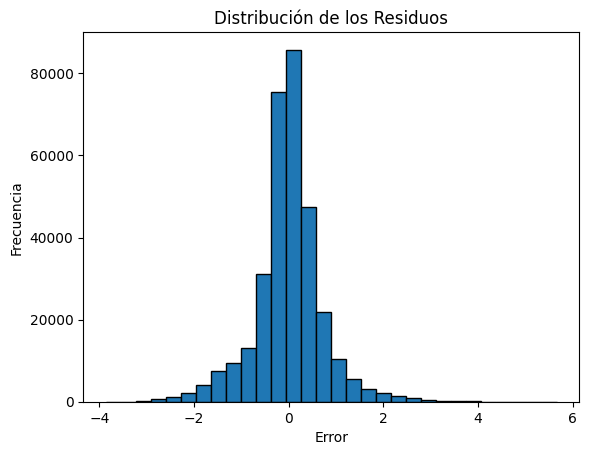

In [6]:
plt.hist(model.resid, bins=30, edgecolor='black')
plt.title("Distribución de los Residuos")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.show()

Se puede ver claramente que tiene un pico muy elevado que aglutina una gran mayoría de los errores mientras que las colas son más ligeras.

El test de Shapiro-Wilk nos indica si es o no una distribución normal, no es necesario después de todo lo que hemos visto, pero es otra prueba más:

In [7]:
stat, p_value = shapiro(model.resid)
print("Shapiro-Wilk Test:")
print("Statistic:", stat)
print("P-value:", p_value)

Shapiro-Wilk Test:
Statistic: 0.9409030604372122
P-value: 8.971942663090362e-121


C:\Users\Carlos\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 324823.
  res = hypotest_fun_out(*samples, **kwds)


Efectivamente el test nos indica al tener un p-value tan tan bajo, que no es normal nuestra distribución de errores.

De esto podemos concluir que los intervalos de confianza en los test de hipotesis de nuestros coeficientes, pueden no ser fiables del todo. Por extensión, es posible que a la hora de predecir, el modelo no sea todo lo robusto y preciso que debería ser.

Entre la información que devuelve hemos visto los valores de R2 y R2 ajustado. Vamos a sacar también el valor del MSE para tenerlo como referencia:

In [8]:
# Predicciones en el conjunto de entrenamiento
y_train_pred = model.predict(X_train)

# MSE en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_train_pred)

print(mse_train)

0.534109903875598


Este valor nos servirá para comparar modelos luego.


### 3. Validación en conjunto de test

Ahora vamos a ver qué tal generaliza nuestro modelo cuando lo aplicamos a un conjunto que aún no ha visto, es decir, al conjunto de test. Estimamos los valores de ***price*** de ese conjunto y obtenemos también los valores de R2 y MSE en este mismo conjunto para ver cuánto difieren de los del set de entrenamiento.

In [9]:
# Agregar un término de intercepción manualmente
X_test = sm.add_constant(X_test)  # Agrega una columna de 1s para el intercepto

# Hacer predicciones con los datos de prueba
y_test_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Coeficiente de Determinación (R²): {r2}")

Error Cuadrático Medio (MSE): 0.5301860059197547
Coeficiente de Determinación (R²): 0.4680689205176657


A la vista del resultado, los valores son prácticamente los mismos que los resultados del test de entrenamiento. Pinta bien.

Ahora vamos a realizar una validación cruzada de forma que entrenemos nuestro modelo en distintas muestras de nuestros datos y los validemos en conjuntos a parte. Esta validación devolverá resultados más robustos para establecer nuestras conclusiones sobre el modelo. Es decir, si todos los modelos entrenados con distintas partes de nuestros datos, tienen las mismas métricas, podemos coger el modelo general a partir de todo el conjunto y estar seguros de que cuando vengan datos nuevos, generalizará bien.

Aplicamos un algoritmo de cross validation con 10 folds y tomamos para valorar tanto el R2 como el MSE. Dado que hemos statsmodel.OLS para generar el modelo y éste no tiene un metodo fit(), debemos "envolver" nuestro modelo en una clase que utilizaremos para simular este método y seguir usando nuestro modelo.

In [10]:
# Definir un envoltorio para el modelo de statsmodels
class StatsmodelsOLS(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.model = None

    def fit(self, X, y):
        # Agregar la constante (intercepto)
        X = sm.add_constant(X)
        self.model = sm.OLS(y, X).fit()
        return self

    def predict(self, X):
        # Agregar la constante (intercepto)
        X = sm.add_constant(X)
        return self.model.predict(X)

# Crear el modelo envuelto
model = StatsmodelsOLS()

Ahora podemos aplicar la validación cruzada de 10 folds y pedirle en primera instancia información sobre el R2 en cada validación

In [11]:
folds = 10
# Realizar validación cruzada con R^2
scores_r2 = cross_val_score(model, X, y, cv=folds, scoring='r2')

# Estadisticas de los R^2
print("R^2 promedio:", scores_r2.mean())
print("R^2 std:", scores_r2.std())
print("R^2 por fold:", scores_r2)

R^2 promedio: 0.3825331019364576
R^2 std: 0.0690876892349218
R^2 por fold: [0.42275346 0.41452762 0.36985995 0.41036395 0.36825844 0.42549946
 0.3999557  0.19008971 0.45092653 0.3730962 ]


Volvemos a hacer la validación cruzada con 10 folds pero para la métrica MSE.

In [12]:
# Validación cruzada con mse como métrica
scores_mse = cross_val_score(model, X, y, cv=folds, scoring=make_scorer(mean_squared_error, greater_is_better=False))

# Estadisticas de los mse
print("mse promedio:", scores_mse.mean())
print("mse std:", scores_mse.std())
print("mse por fold:", scores_mse)

mse promedio: -0.6157135433302463
mse std: 0.11559829812587355
mse por fold: [-0.62463424 -0.52174235 -0.59727894 -0.60076888 -0.51006056 -0.57364015
 -0.51971762 -0.87959058 -0.54748773 -0.78221438]


Vamos a pintarnos ambas distribuciones de cada métrica para ver qué pinta tienen:

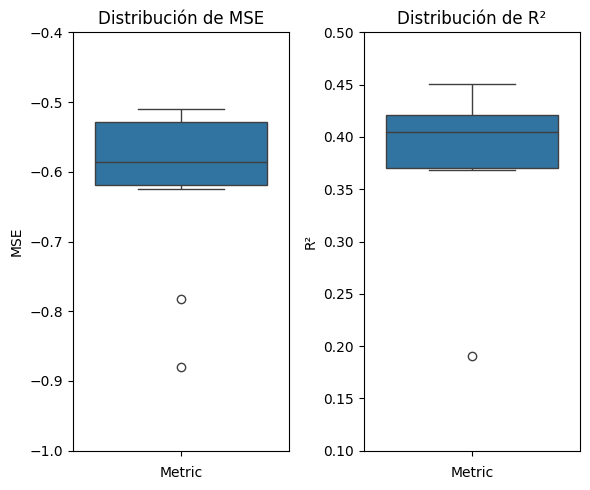

In [13]:
# Convertir las métricas en DataFrame para visualización
metrics_df1 = pd.DataFrame({
    "Fold": np.arange(1, folds+1),
    "MSE": scores_mse,
    "R²": scores_r2,
    "Modelo": "Original"
})

# Boxplots para las métricas
plt.figure(figsize=(6, 5))

# MSE
plt.subplot(1, 2, 1)
sns.boxplot(data=metrics_df1, y="MSE")
plt.title("Distribución de MSE")
plt.ylabel("MSE")
plt.xlabel("Metric")
plt.ylim(-1, -0.4)

# R²
plt.subplot(1, 2, 2)
sns.boxplot(data=metrics_df1, y="R²")
plt.title("Distribución de R²")
plt.ylabel("R²")
plt.xlabel("Metric")
plt.ylim(0.1, 0.5)

plt.tight_layout()
plt.show()

En vista de los valores devueltos, parece que no hay excesiva dispersión entre ellos, por lo que podríamos concluir que generaliza bien. Es cierto que en algún fold se sube un 50% el MSE y baja mucho el R2. Habría que trabajar un poco sobre esto para conseguir una distribución más consistente.


### 4. Estimación de la importancia relativa de las variables

Ahora vamos a analizar la importancia de cada variable respecto del total de todas ellas. Esto nos va a dar una especie de ranking en el que vamos a poder ver de forma ordenada cuales son las variables que mayor relevancia tienen para el modelo. Nos ayudará a hacer selección de variables entre otras cosas.

In [14]:
# Calculamos importancia relativa
df_relativeImp = relativeImp(X.join(y), outcomeName = 'price', driverNames = X.columns.tolist())

#pd.set_option('display.max_rows', None) # visualizar todas las filas con todas las variables

# Ordenamos valores 
df_relativeImp=df_relativeImp.sort_values(by='normRelaImpt', ascending=False)

# Añadimos los coeficientes del modelo de regresión lineal de cada variable 
df_relativeImp['Coeficientes'] = df_relativeImp['driver'].map(coef)
df_relativeImp.head(10)

,driver,rawRelaImpt,normRelaImpt,Coeficientes
1,odometer,0.126177,27.034498,-0.332615
0,year,0.077918,16.694644,0.228062
56,fuel_gas,0.038221,8.189223,-0.804197
65,transmission_other,0.028668,6.142403,0.233587
75,type_pickup,0.022615,4.845508,0.372593
66,drive_fwd,0.016919,3.624940,-0.162216
50,cylinders_4 cylinders,0.016697,3.577469,-0.337734
76,type_sedan,0.014681,3.145492,-0.131003
53,cylinders_8 cylinders,0.010229,2.191573,0.060722
52,cylinders_6 cylinders,0.007606,1.629609,-0.098984


A la vista del listado, se ve claramente que las variables numéricas son las que más aportan al modelo y después algunas de las que teníamos ubicadas como que iban a ser relvantes. Los coeficientes nos muestran como por ejemplo con la variable ***odometer*** hay una relación inversa y muy fuerte. Se trata de un coeficiente con valor -1.47 que al ser negativo, nos indica esta relación inversa. A mayor kilometraje, menor precio. Con ***year*** sin embargo la relación es directa y así lo muestra el coeficiente. Al ser positivo, cuanto más antiguo sea el coche menor será el precio.

Otras variables relevantes como por ejemplo ***fuel_gas*** también presenta una relación inversa. Esto es porque esta variable es 1 cuando el vehículo es de gasolina y 0 cuando es de otro tipo de combustible (electrico, diesel, etc). Es decir que cuanto esta variable aumenta al pasar de 0 a 1, el precio disminuye ya que en general los de gasolina tienen menor precio según los boxplots del analisis exploratorio. Se pueden extraer muchas conclusiones de todos estos coeficientes.  

Y si lo ponemos en un gráfico de barras... mejor

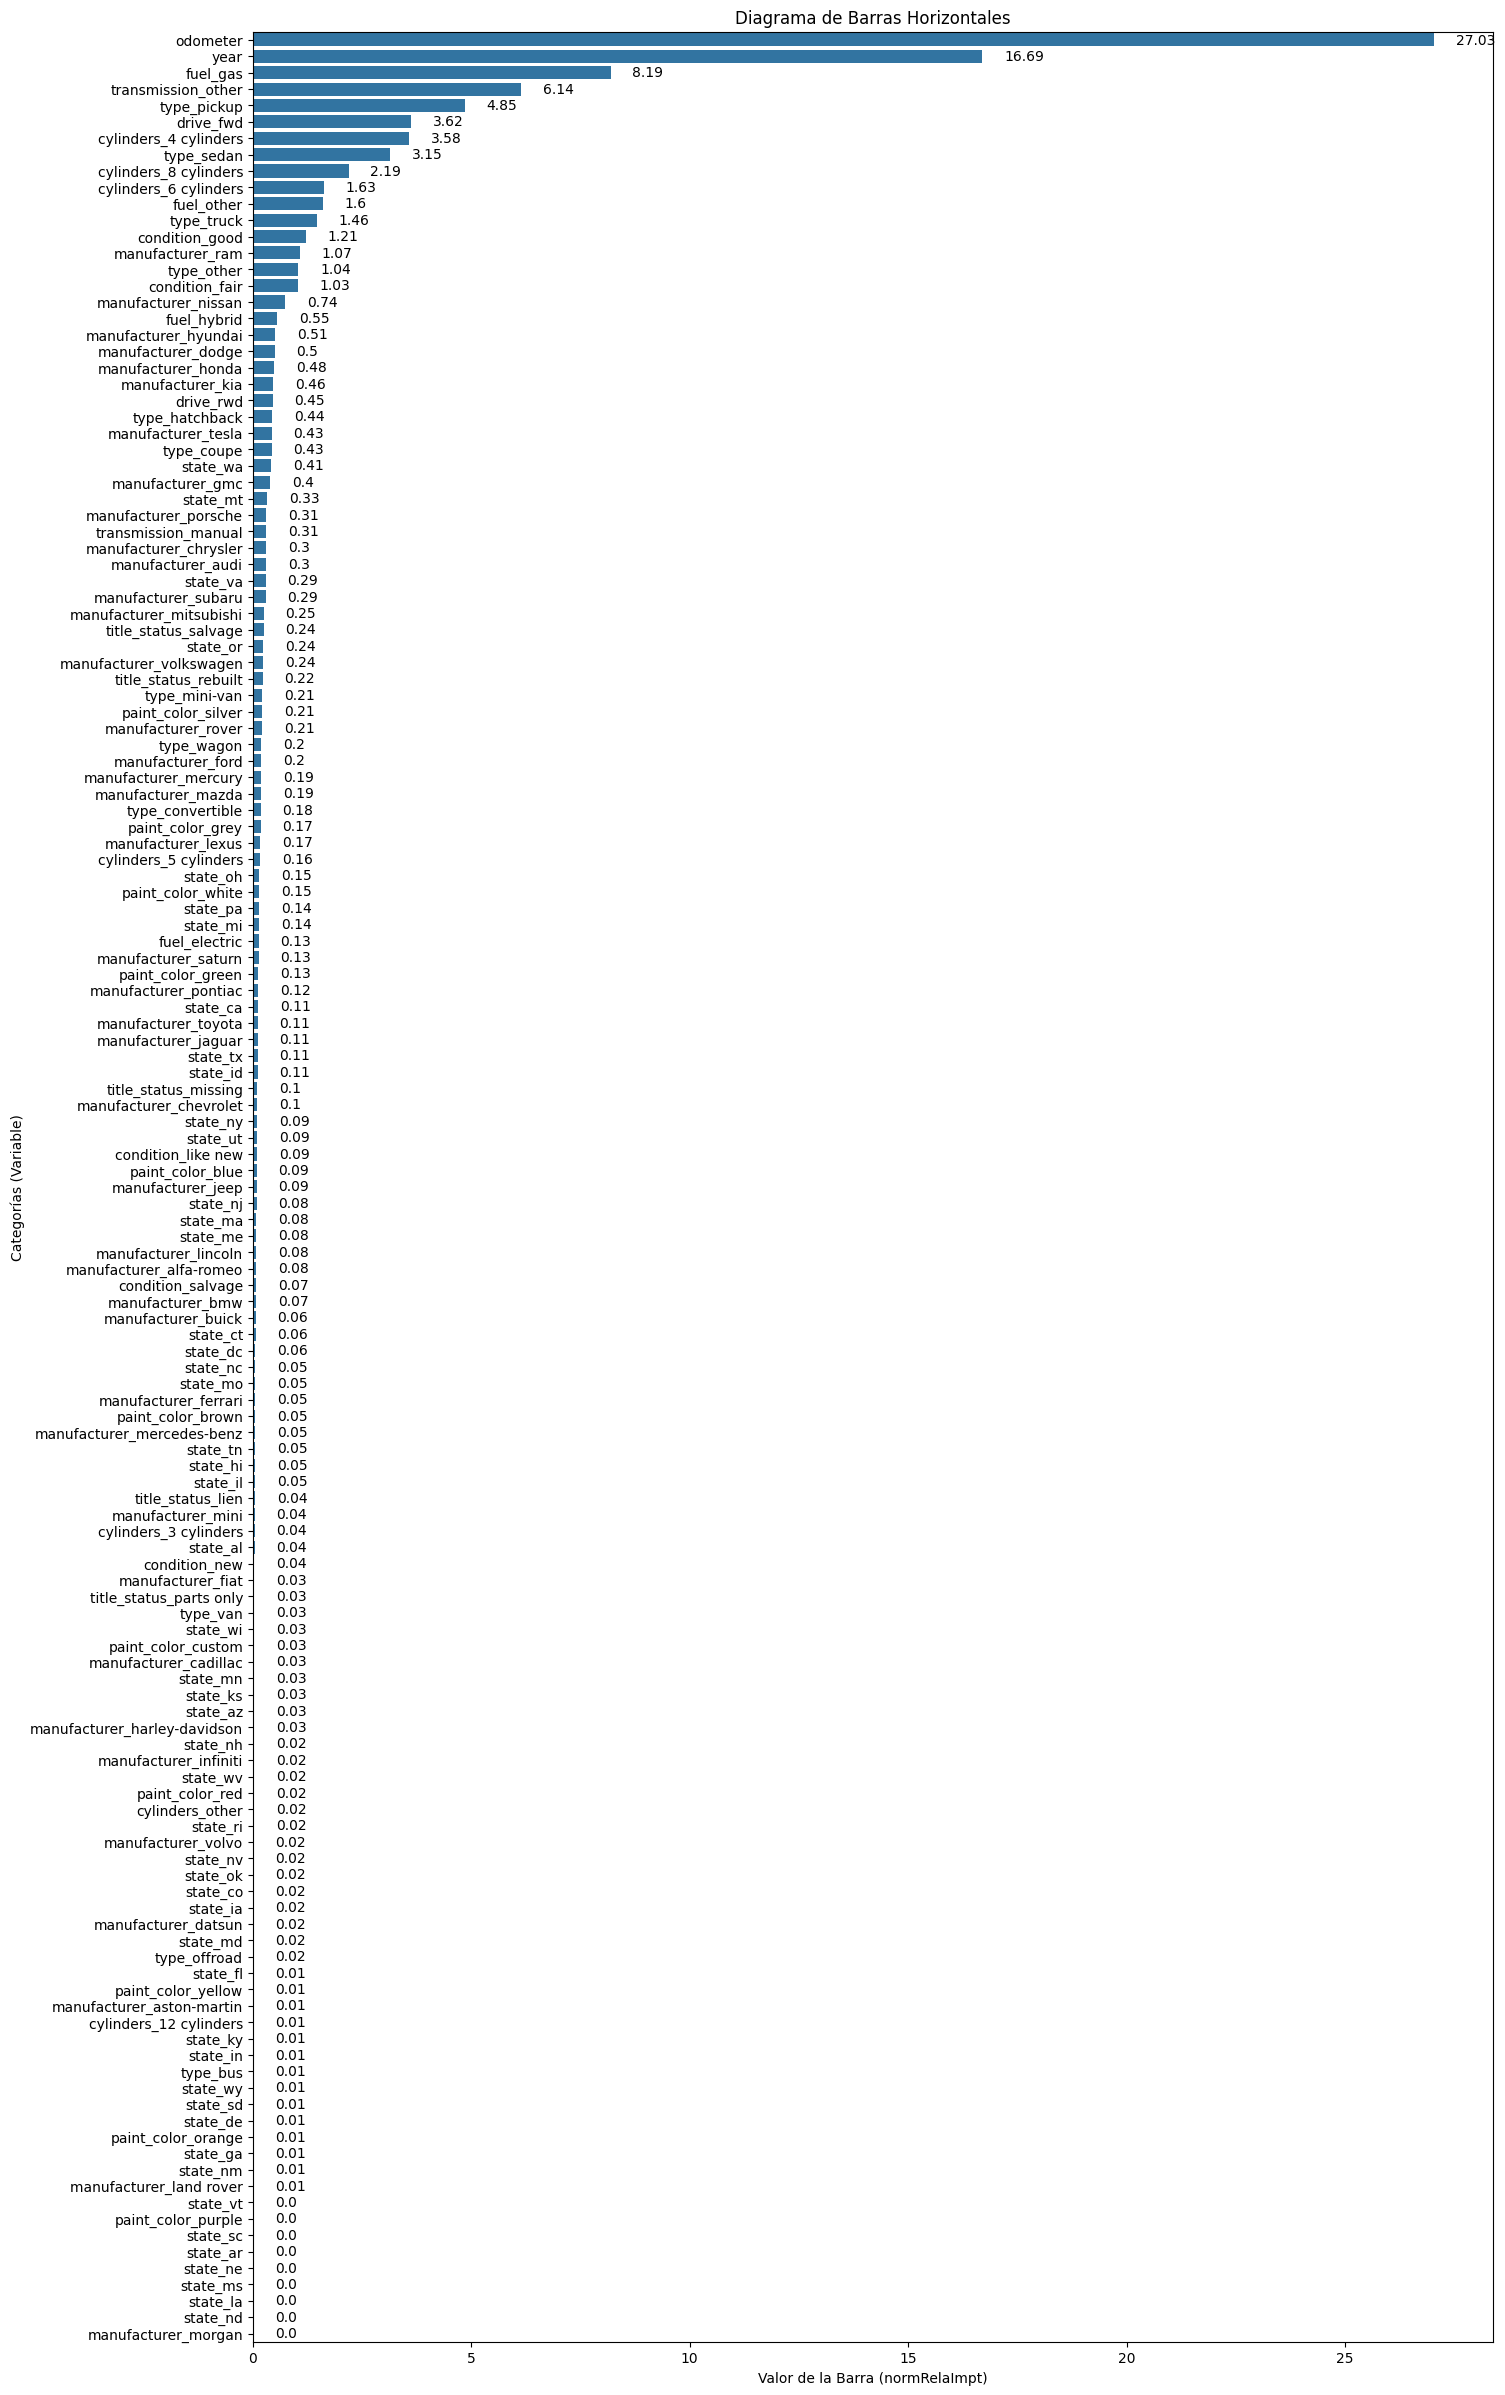

In [15]:
# Crear el diagrama de barras horizontales
plt.figure(figsize=(16, 30)) # Ajusta el tamaño del gráfico (ancho, alto)
ax = sns.barplot(x='normRelaImpt', y='driver', data=df_relativeImp, orient='h')

# Añadir los valores a la derecha de las barras
for index, value in enumerate(df_relativeImp['normRelaImpt']):
    ax.text(value + 0.5, index, f'{round(value, 2)}', va='center', ha='left')

# Etiquetas y título
plt.xlabel('Valor de la Barra (normRelaImpt)')
plt.ylabel('Categorías (Variable)')
plt.title('Diagrama de Barras Horizontales')

# Mostrar el gráfico
plt.show()

### 5. Transformacion de los datos para mejorar el modelo

Dada la importancia de las variables ***odometer*** y ***year*** vamos a probar a aplicarles una transformación a ver si con ello conseguimos mejorar algun parametro de nuestro modelo.

Empezamos con la variable ***odometer***. Vamos a aplicarle una transformación de tipo BoxCox tratando de linealizar un poco su comportamiento para ver si aumenta su relación con la variable ***price***. Esto lo medimos a través de la matriz de correlación.

In [16]:
print(f"Factor de correlación entre price y odometer antes de transformar : {data['price'].corr(data['odometer'])}")

# Transformación de odometer mediante BoxCox
data['odometer'], _ = boxcox(data['odometer'] + abs(data['odometer'].min()) + 1)

print(f"Factor de correlación entre price y odometer después de transformar : {data['price'].corr(data['odometer'])}")

Factor de correlación entre price y odometer antes de transformar : -0.45512254278127523
Factor de correlación entre price y odometer después de transformar : -0.4738764690573044


El factor de correlación ha aumentado tras haber transformado la variable por lo que vamos a mantener esta transformación y la incluimos en el modelo a ver que tal le sienta.

Ahora hacemos lo mismo con ***year*** a ver si esta transformación le sienta bien:

In [17]:
print(f"Factor de correlación entre price y year antes de transformar : {data['price'].corr(data['year'])}")

# Transformación de odometer mediante BoxCox
data['year'], _ = boxcox(data['year'] + abs(data['year'].min()) + 1)

print(f"Factor de correlación entre price y year después de transformar : {data['price'].corr(data['year'])}")

Factor de correlación entre price y year antes de transformar : 0.37584518256867944
Factor de correlación entre price y year después de transformar : 0.4939403974341185


En este caso la correlación ha subido mucho por lo que la incluimos también.

Volvemos a modelar los datos, esta vez con las 2 variables transformadas:

In [18]:
# Redefinir la variable objetivo (y) y las predictoras (X) incluyendo las transformadas
X = data.drop('price', axis=1)
y = data['price']

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Agregar un término de intercepción manualmente
X_train = sm.add_constant(X_train)  # Agrega una columna de 1s para el intercepto

# Crear y ajustar el modelo
model = sm.OLS(y_train, X_train).fit()

# Extraer los coeficientes
coef = model.params

# Mostrar el resumen detallado del modelo
print(model.summary())

# Predicciones en el conjunto de entrenamiento
y_train_pred = model.predict(X_train)

# MSE en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_train_pred)

print(f"mse: {mse_train}")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     2271.
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:09:47   Log-Likelihood:            -3.4959e+05
No. Observations:              324823   AIC:                         6.995e+05
Df Residuals:                  324681   BIC:                         7.010e+05
Df Model:                         141                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

A la vista de los resultados del modelo, el R2 ha subido a 0.50 practicamente y también ha bajado ligeramente el MSE, por lo que en esos términos, nuestro modelo ha mejorado. Si evaluamos el resto de métricas devueltas el AIC y el BIC tambien se ha reducido ligeramente, cosa que también es buena.

Sin embargo, los residuos siguen presentando el mismo problema con la curtosis, es demasiado elevada y por tanto saca la distribución de la normalidad.

Vamos a aplicar validación cruzada para ver como se comportan las métricas ya en conjuntos de validación y ver si generalizan bien los modelos para el conjunto nuevo que tenemos.

In [19]:
# Crear el modelo envuelto
model = StatsmodelsOLS()

folds = 10
# Realizar validación cruzada con R^2
scores_r2 = cross_val_score(model, X, y, cv=folds, scoring='r2')

# Estadisticas de los R^2
print("R^2 promedio:", scores_r2.mean())
print("R^2 std:", scores_r2.std())
print("R^2 por fold:", scores_r2)

R^2 promedio: 0.4224237434638898
R^2 std: 0.07286456261459023
R^2 por fold: [0.44841795 0.44326158 0.4226316  0.45638436 0.4213443  0.45915437
 0.4513869  0.21517109 0.49675542 0.40972987]


In [20]:
# Crear el modelo envuelto
model = StatsmodelsOLS()

# Validación cruzada con mse como métrica
scores_mse = cross_val_score(model, X, y, cv=folds, scoring=make_scorer(mean_squared_error, greater_is_better=False))

# Estadisticas de los mse
print("mse promedio:", scores_mse.mean())
print("mse std:", scores_mse.std())
print("mse por fold:", scores_mse)

mse promedio: -0.5767192132633265
mse std: 0.11792365339290722
mse por fold: [-0.59686289 -0.49613615 -0.54725928 -0.55387956 -0.46719968 -0.54003565
 -0.47517141 -0.85235134 -0.50179119 -0.73650501]


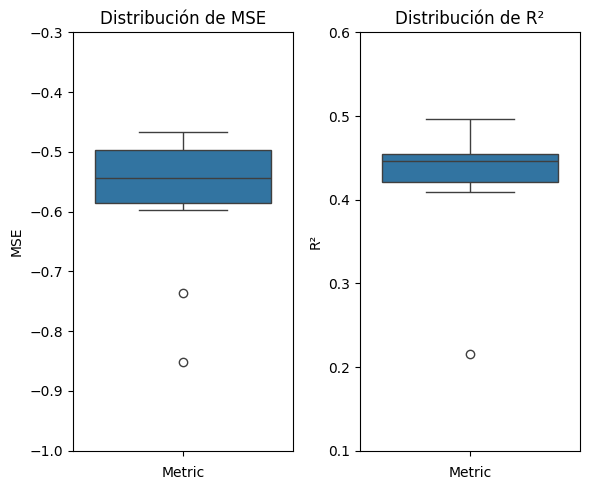

In [21]:
# Convertir las métricas en DataFrame para visualización
metrics_df2 = pd.DataFrame({
    "Fold": np.arange(1, folds+1),
    "MSE": scores_mse,
    "R²": scores_r2,
    "Modelo": "Transformado"
})

# Boxplots para las métricas
plt.figure(figsize=(6, 5))

# MSE
plt.subplot(1, 2, 1)
sns.boxplot(data=metrics_df2, y="MSE")
plt.title("Distribución de MSE")
plt.ylabel("MSE")
plt.xlabel("Metric")
plt.ylim(-1, -0.3)

# R²
plt.subplot(1, 2, 2)
sns.boxplot(data=metrics_df2, y="R²")
plt.title("Distribución de R²")
plt.ylabel("R²")
plt.xlabel("Metric")
plt.ylim(0.1, 0.6)

plt.tight_layout()
plt.show()

Los resultados de validación para ambas métricas muestran mejoría respecto de la validación que hicimos con el dataset sin transformar. Esto se ve claramente en que la distribución de valores de R2 se encuentra más arriba que antes e incluso un poco menos dispersa, y la distribución de MSE está muchos menos dispersa y un poco más baja que la otra.

Seguimos teniendo un fold en el que los ratios empeoran mucho, quizá debido a algún conjunto de valores atípicos que no hemos tenido en cuenta en nuestro analisis exploratorio y quizá convendría volver sobre ello y entender bien qué está ocurriendo ahí.


### 6. Eliminación de variables poco relevantes para mejorar el modelo

Vamos a realizar una última iteración para tratar de analizar qué ocurre si quitamos todas las variables ***state***. La idea es que, según la importancia relativa de las variables, las de ***state*** tienen nula o casi nula en practicamente todas sus variables. Vamos a ver si al quitarlas, vemos algún cambio o mejora en nuestro modelo.

In [22]:
# Definir la variable objetivo (y) y las predictoras (X)
X = data.drop('price', axis=1)
y = data['price']

# Crear una lista de columnas a conservar
columns_to_keep = [col for col in X.columns if not col.startswith(('state'))]

# Filtrar el DataFrame
X = X[columns_to_keep]

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Agregar un término de intercepción manualmente
X_train = sm.add_constant(X_train)  # Agrega una columna de 1s para el intercepto

# Crear y ajustar el modelo
model = sm.OLS(y_train, X_train).fit()

# Extraer los coeficientes
coef = model.params

# Mostrar el resumen detallado del modelo
print(model.summary())

# Predicciones en el conjunto de entrenamiento
y_train_pred = model.predict(X_train)

# MSE en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_train_pred)

print(f"mse: {mse_train}")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     3403.
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:12:35   Log-Likelihood:            -3.5228e+05
No. Observations:              324823   AIC:                         7.047e+05
Df Residuals:                  324731   BIC:                         7.057e+05
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [23]:
# Crear el modelo envuelto
model = StatsmodelsOLS()

folds = 10
# Realizar validación cruzada con R^2
scores_r2 = cross_val_score(model, X, y, cv=folds, scoring='r2')

# Estadisticas de los R^2
print("R^2 promedio:", scores_r2.mean())
print("R^2 std:", scores_r2.std())
print("R^2 por fold:", scores_r2)

R^2 promedio: 0.4811741173694001
R^2 std: 0.06990119109132162
R^2 por fold: [0.44639606 0.4515016  0.51508085 0.51094034 0.54872678 0.50077461
 0.5398396  0.29780245 0.53186031 0.46881857]


In [24]:
# Crear el modelo envuelto
model = StatsmodelsOLS()

# Validación cruzada con mse como métrica
scores_mse = cross_val_score(model, X, y, cv=folds, scoring=make_scorer(mean_squared_error, greater_is_better=False))

# Estadisticas de los mse
print("mse promedio:", scores_mse.mean())
print("mse std:", scores_mse.std())
print("mse por fold:", scores_mse)

mse promedio: -0.5199334548182292
mse std: 0.11526165027711342
mse por fold: [-0.59905076 -0.48879307 -0.45963115 -0.49829352 -0.36435259 -0.49847773
 -0.39855969 -0.76261082 -0.46678768 -0.66277754]


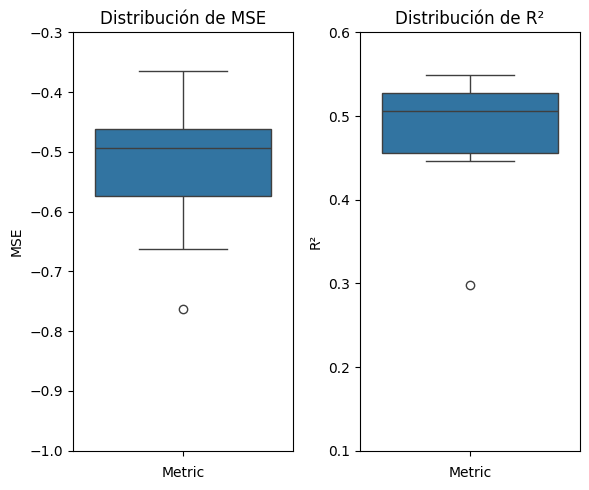

In [25]:
# Convertir las métricas en DataFrame para visualización
metrics_df3 = pd.DataFrame({
    "Fold": np.arange(1, folds+1),
    "MSE": scores_mse,
    "R²": scores_r2,
    "Modelo": "Transf_sin State"
})

# Boxplots para las métricas
plt.figure(figsize=(6, 5))

# MSE
plt.subplot(1, 2, 1)
sns.boxplot(data=metrics_df3, y="MSE")
plt.title("Distribución de MSE")
plt.ylabel("MSE")
plt.xlabel("Metric")
plt.ylim(-1, -0.3)

# R²
plt.subplot(1, 2, 2)
sns.boxplot(data=metrics_df3, y="R²")
plt.title("Distribución de R²")
plt.ylabel("R²")
plt.xlabel("Metric")
plt.ylim(0.1, 0.6)

plt.tight_layout()
plt.show()

Tras analizar este último cambio, ponemos los 3 modelos sobre la mesa y valoramos cual consideramos mejor en términos de estas 2 métricas con las que estamos trabajando:

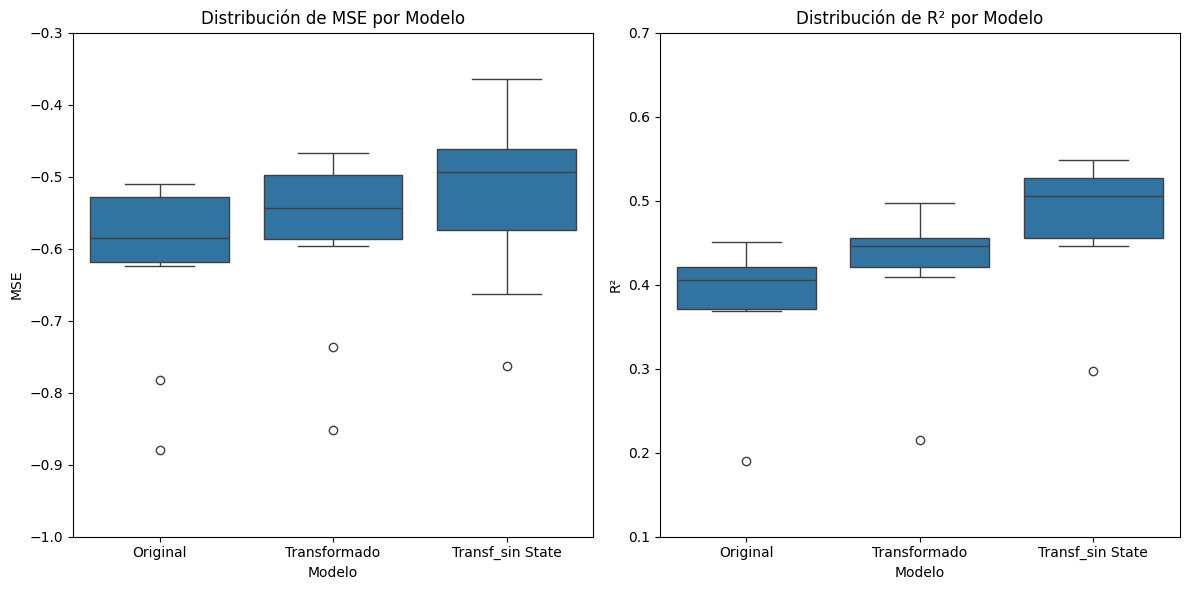

In [26]:
# Concatenar los DataFrames
all_metrics_df = pd.concat([metrics_df1, metrics_df2, metrics_df3], ignore_index=True)

# Boxplots para las métricas por modelo
plt.figure(figsize=(12, 6))

# MSE
plt.subplot(1, 2, 1)
sns.boxplot(data=all_metrics_df, x="Modelo", y="MSE")
plt.title("Distribución de MSE por Modelo")
plt.ylabel("MSE")
plt.xlabel("Modelo")
plt.ylim(-1, -0.3)

# R²
plt.subplot(1, 2, 2)
sns.boxplot(data=all_metrics_df, x="Modelo", y="R²")
plt.title("Distribución de R² por Modelo")
plt.ylabel("R²")
plt.xlabel("Modelo")
plt.ylim(0.1, 0.7)

plt.tight_layout()
plt.show()

Claramente, el modelo ha ido mejorando las métricas con los cambios que hemos ido aplicando. Empezamos con un modelo con un R2 en torno a 0.4 y acabamos en torno a 0.5. El MSE también ha ido mejorando, puesto que empezamos con un valor mediano cercano a -0.6 y hemos terminado por debajo del -0.5. Es cierto, que en ambas métricas, parece que el modelo generaliza un poco peor al haber más dispersión en el último modelo respecto del primero o el segundo.

Con esto terminamos la práctica referida a la regresión lineal donde hemos visto cómo construir un modelo de regresión lineal, lo hemos interpretado, validado e incluso hemos aplicado correcciones sobre nuestros datos para buscar un mejor modelo. Es fundamental entender bien las variables y ser imaginativos a la hora de probar y validar nuestros modelos puesto que al final, todo lo que invirtamos aquí, merecerá la pena para conseguir un modelo que en definitiva haga mejores predicciones.